-----------------------------------------------------------------------------------------------

### Imports and pulling data into pandas


In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly

from greykite.common.evaluation import EvaluationMetricEnum
from greykite.framework.templates.forecaster import Forecaster
from greykite.algo.forecast.silverkite.constants.silverkite_column import SilverkiteColumn
from greykite.framework.templates.autogen.forecast_config import ComputationParam
from greykite.framework.templates.autogen.forecast_config import EvaluationMetricParam
from greykite.framework.templates.autogen.forecast_config import EvaluationPeriodParam
from greykite.framework.templates.autogen.forecast_config import MetadataParam
from greykite.framework.templates.autogen.forecast_config import ForecastConfig
from greykite.framework.templates.model_templates import ModelTemplateEnum
from greykite.framework.input.univariate_time_series import UnivariateTimeSeries
from greykite.framework.utils.result_summary import summarize_grid_search_results
from greykite.framework.constants import MEAN_COL_GROUP, OVERLAY_COL_GROUP
from greykite.framework.templates.autogen.forecast_config import ModelComponentsParam
from greykite.common.viz.timeseries_plotting import plot_multivariate


pd.set_option('display.max_rows', 100)
plt.set_loglevel('WARNING')

In [2]:
df_train = pd.read_excel('timeseries_forecasting_test.xlsx', sheet_name='train', engine='openpyxl', parse_dates=['interval_et'])
df_test = pd.read_excel('timeseries_forecasting_test.xlsx', sheet_name='test', engine='openpyxl', parse_dates=['interval_et'])


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32613 entries, 0 to 32612
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   interval_et  32613 non-null  datetime64[ns]
 1   chats        32613 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 509.7 KB


In [4]:
# Find the earliest and latest dates
earliest_date = df_train['interval_et'].min()
latest_date = df_train['interval_et'].max()

# Calculate the difference in years
years_of_data = (latest_date - earliest_date).days / 365

print("Years of data from earliest date:", years_of_data)

Years of data from earliest date: 2.745205479452055


-------------------------------------------------------------------------------------------------

### Transforming data into day periodicity

Appears that if a 15 minute period has no chats, it is not in the dataset. We will need to add this back in and represent it as a 0 for that period.

In [5]:
daily_df = df_train.groupby(pd.Grouper(key='interval_et', freq='D')).sum().reset_index()
daily_df_test = df_test.groupby(pd.Grouper(key='interval_et', freq='D')).sum().reset_index()


In [6]:
daily_df.head()

interval_et  chats
0  2020-01-02    220
1  2020-01-03    205
2  2020-01-04      0
3  2020-01-05      0
4  2020-01-06    270

In [7]:
# Need future dates with null chats because the extra variables need future data
max_date = daily_df['interval_et'].max()

new_dates = pd.date_range(start=max_date + pd.Timedelta(days=1), periods=180)

new_df = pd.DataFrame({
    'interval_et': new_dates,
    'chats': np.nan
})

daily_df = daily_df.append(new_df, ignore_index=True)

In [8]:
daily_df.tail()

interval_et  chats
1178  2023-03-25    NaN
1179  2023-03-26    NaN
1180  2023-03-27    NaN
1181  2023-03-28    NaN
1182  2023-03-29    NaN

In [9]:
# adding in idenifier for whether the day falls in the last week of the year, data seems to behave differently that week
daily_df['is_last_week_of_year'] = daily_df['interval_et'].apply(lambda x: x.month == 12 and x.day >= 22 or (x.month == 1 and x.day <= 1)).astype('int')
daily_df_test['is_last_week_of_year'] = daily_df_test['interval_et'].apply(lambda x: x.month == 12 and x.day >= 22 or (x.month == 1 and x.day <= 1)).astype('int')

daily_df.tail()

interval_et  chats  is_last_week_of_year
1178  2023-03-25    NaN                     0
1179  2023-03-26    NaN                     0
1180  2023-03-27    NaN                     0
1181  2023-03-28    NaN                     0
1182  2023-03-29    NaN                     0

In [10]:
# descriptive stats for all data
daily_df[['chats']].describe()

chats
count  1003.000000
mean    418.424726
std     335.788275
min       0.000000
25%       0.000000
50%     444.000000
75%     684.000000
max    1206.000000

In [11]:
# descriptive stats for last day of year
daily_df[daily_df['is_last_week_of_year']==1][['chats']].describe()

chats
count   22.000000
mean   204.000000
std    194.742321
min      0.000000
25%      0.000000
50%    229.500000
75%    378.500000
max    547.000000

----------------------------------------------------------------------------------------

### Exploring Silverkite algorithm with simple daily linear model
In later cells, we will examine seasonailty patterns picked up by the model.

In [12]:
model_components = ModelComponentsParam(
    growth={
        "growth_term": "linear"  
    },
)

metadata = MetadataParam(
   time_col="interval_et",  
   value_col="chats",  
   freq="D",
)


forecaster = Forecaster() 
result = forecaster.run_forecast_config(  
    df=daily_df,
    config=ForecastConfig(
        model_template=ModelTemplateEnum.SILVERKITE.name,
        forecast_horizon=100,  
        coverage=0.95,         # 95% prediction intervals
        metadata_param=metadata,
        model_components_param=model_components 
 )
)

# using cross validation to reduce risk overfitting
cv_results = summarize_grid_search_results(
     grid_search=result.grid_search,
     decimals=1,
     cv_report_metrics=["MeanAbsoluteError"],
     column_order=["mean_test_MAE"])

cv_results

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/erinyao/miniconda3/envs/time_series/lib/python3.10/site-packages/greykite/framework/utils/result_summary.py:144: RuntimeWarning: invalid value encountered in cast
  ranks = np.asarray(rankdata(scores, method='min'), dtype=np.int32)


mean_test_MAE
0          135.2

----------------------------------------------------------------

### Exploring seasonal patterns

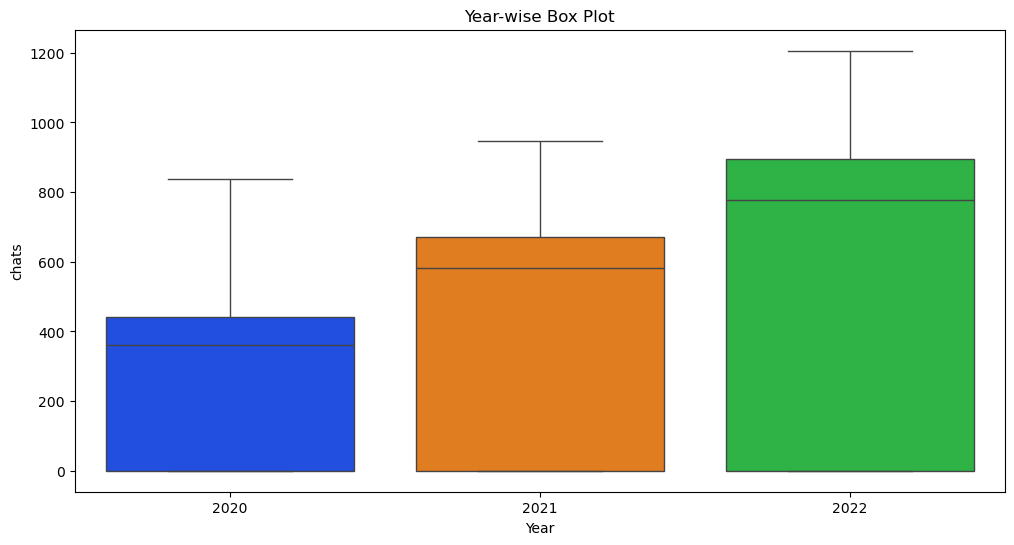

In [13]:
# Box plots by year intervals to observe seasonal effects
# Can see trend is increasing year over year
%matplotlib inline
daily_df_season_params = daily_df[~daily_df['chats'].isnull()]
daily_df_season_params = daily_df_season_params.set_index('interval_et')
daily_df_season_params['Year'] = daily_df_season_params.index.year
daily_df_season_params['Month'] = daily_df_season_params.index.month
daily_df_season_params['chats'] = daily_df_season_params['chats']
plt.figure(figsize=(12, 6))
sns.boxplot(x='Year', y='chats', data=daily_df_season_params, palette='bright')
plt.title('Year-wise Box Plot')
plt.show()


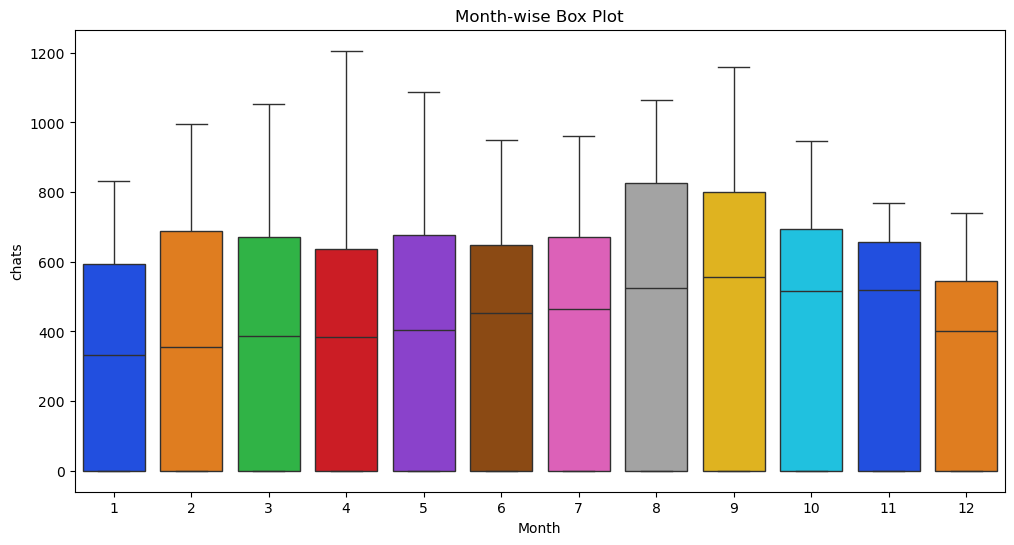

In [14]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Month', y='chats', data=daily_df_season_params, palette='bright')
plt.title('Month-wise Box Plot')
plt.show()

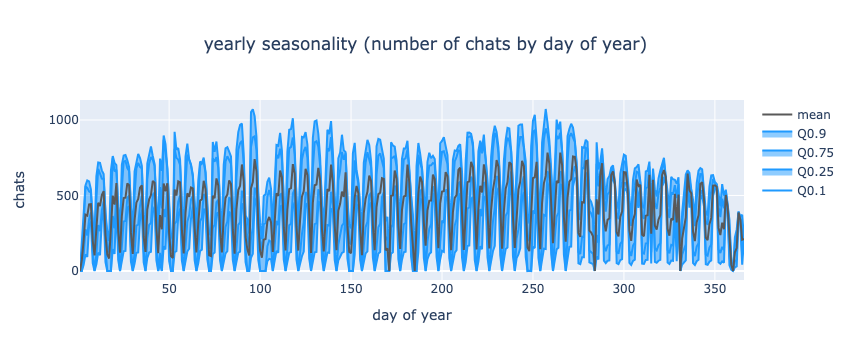

In [15]:
# weekly seasonality shows up here - makes sense since weekend volume is almost always 0
ts = result.timeseries  
fig = ts.plot_quantiles_and_overlays(
     groupby_time_feature="doy",
     show_mean=True,
     show_quantiles=[0.1, 0.25, 0.75, 0.9],  # specifies quantiles to include
     xlabel="day of year",
     ylabel=ts.original_value_col,
     title="yearly seasonality (number of chats by day of year)",
 )
plotly.io.show(fig)

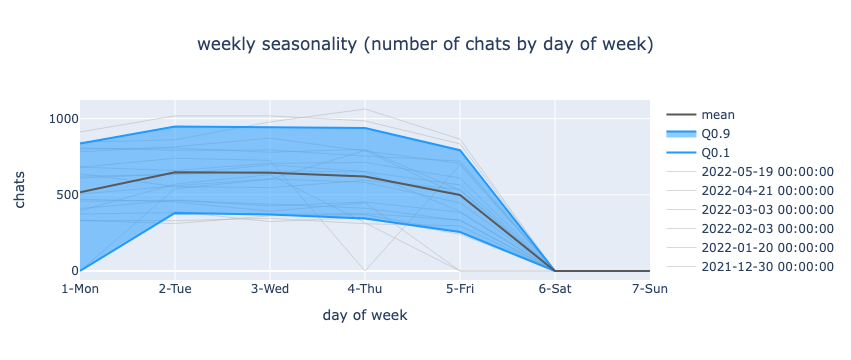

In [16]:
# Almost no chats happen on weekends, lower volume on Mondays and Fridays, Tuesday-Thursday see most volume.
fig = ts.plot_quantiles_and_overlays(
    groupby_time_feature="str_dow",
    show_mean=True,
    show_quantiles=True,
    show_overlays=20,  # randomly selects up to 20 overlays
    overlay_label_sliding_window_size=7,  # each overlay is a single cycle (week)
    center_values=False,
    xlabel="day of week",
    ylabel=ts.original_value_col,
    title="weekly seasonality (number of chats by day of week)"
 )
plotly.io.show(fig)

--------------------------------------------------------------

### Training Performance

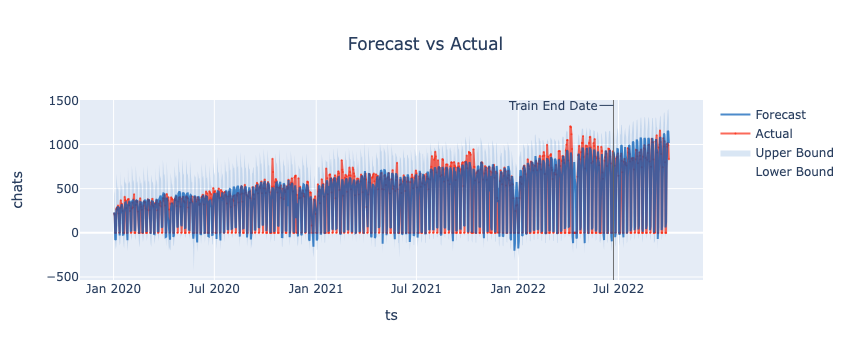

In [17]:
# April 8th - April 18th 2022, no data for about 10 days. Was there a loss of data, migration, product issue, etc?
# Also see a spike in chats the days before it.

backtest = result.backtest
fig = backtest.plot()
plotly.io.show(fig)



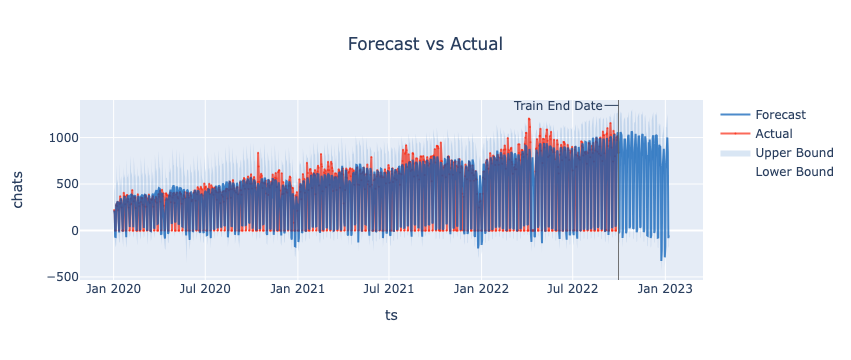

In [18]:
forecast = result.forecast
fig = forecast.plot()
plotly.io.show(fig)

In [38]:
# save model within notebook
model = result.model

# examining default params used in model
#model.get_params()

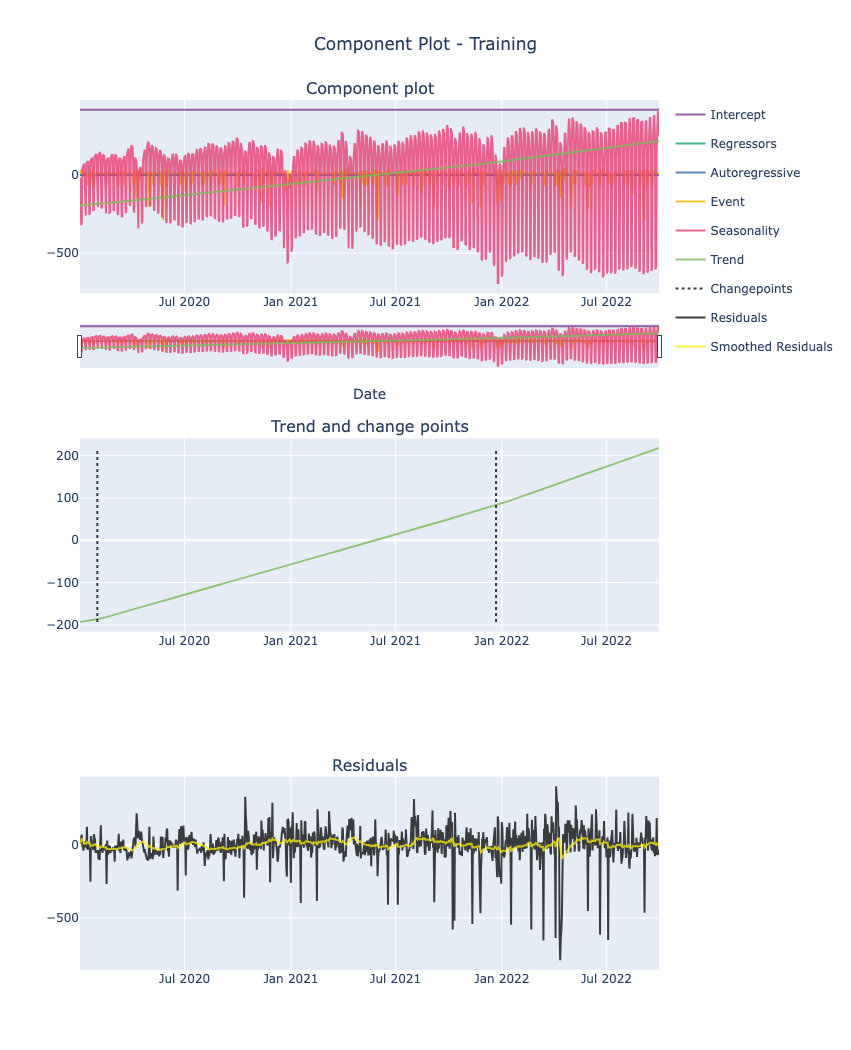

In [20]:
# Model does poorly (big residuals) April 8th - April 18th 2022, no data for about 10 days, but that's expected 
# because it's suprise behavior that doesn't appear elsewhere.
fig = forecast.plot_components()
plotly.io.show(fig) 

In [21]:
print(backtest.test_evaluation)  # backtest training set
print()
print(forecast.train_evaluation)   # hold out test set

{'CORR': 0.9473681799412751, 'R2': 0.8816780702310042, 'MSE': 20787.45746162712, 'RMSE': 144.17856103327955, 'MAE': 106.42078756815609, 'MedAE': 81.1751826559047, 'MAPE': None, 'MedAPE': None, 'sMAPE': 34.43928845726684, 'Q80': 39.973443731114386, 'Q95': 33.35496870463255, 'Q99': 31.59004203090407, 'OutsideTolerance1p': 0.97, 'OutsideTolerance2p': 0.93, 'OutsideTolerance3p': 0.91, 'OutsideTolerance4p': 0.89, 'OutsideTolerance5p': 0.84, 'Outside Tolerance (fraction)': None, 'R2_null_model_score': None, 'Prediction Band Width (%)': None, 'Prediction Band Coverage (fraction)': 0.98, 'Coverage: Lower Band': 0.75, 'Coverage: Upper Band': 0.23, 'Coverage Diff: Actual_Coverage - Intended_Coverage': 0.030000000000000027, 'MIS': 569.4043207976866}

{'CORR': 0.9387442066754556, 'R2': 0.8809691351898017, 'MSE': 13407.797187207083, 'RMSE': 115.79204284926958, 'MAE': 70.75769101455359, 'MedAE': 44.73852284238774, 'MAPE': None, 'MedAPE': None, 'sMAPE': 35.945449209448945, 'Q80': 35.37884550727676, '

-------------------------------------------

# Grid Search for parameter tuning

In [22]:
seasonality = {
    "yearly_seasonality": [5, 10],
    "quarterly_seasonality": [False, 5, 10, 15],
    "monthly_seasonality":[False, 5, 10 ,15],
    "weekly_seasonality": [False, 5, 10, 15],
    "daily_seasonality": False # data is at daily aggregate level already so no daily seasonality
    }

custom = {
 'feature_sets_enabled':
     {SilverkiteColumn.COLS_WEEKEND_SEAS:'auto'}, # weekend are very different from weekdays, so include this
 "fit_algorithm_dict": [
     {"fit_algorithm": "ridge"},
     {"fit_algorithm": "linear", "fit_algorithm_params": dict(missing="drop")}],
  "min_admissible_value" : 0 # chat volumes less than 0 don't make practical sense
}


computation = ComputationParam(
    n_jobs=-1,
    hyperparameter_budget=75 #save time by running 75 random iterations of the grid params
)

model_components = ModelComponentsParam(
    autoregression=dict(autoreg_dict='auto'),
    seasonality=seasonality,
    #changepoints = changepoints,
    growth={"growth_term":["linear"]},  
    events={
            "auto_holiday" : True,
            "holiday_lookup_countries": ["US"], # account for US holidays
            "holiday_pre_num_days" : 0,         # may be useful in future to tune because of holiday shopping season
            "holiday_post_num_days" : 0
    },
    regressors = {'regressor_cols': ["is_last_week_of_year"]},
    custom=custom
    )

# Specifies the evaluation period
evaluation_period = EvaluationPeriodParam(
     test_horizon=180,             
     cv_horizon=365,                
     cv_max_splits=3,              
     cv_min_train_periods=365      
    )

evaluation_metric = EvaluationMetricParam(
     cv_report_metrics=[EvaluationMetricEnum.RootMeanSquaredError.name,
                        EvaluationMetricEnum.MeanAbsoluteError.name ],
     cv_selection_metric=EvaluationMetricEnum.RootMeanSquaredError.name
    )

config = ForecastConfig(
    model_template="SILVERKITE",
    forecast_horizon=90,
    coverage=0.95,
    model_components_param=model_components,
    evaluation_metric_param=evaluation_metric,
    evaluation_period_param=evaluation_period,
    computation_param=computation,
    metadata_param=metadata,
    )

In [23]:
metadata = MetadataParam(
    time_col="interval_et", 
    value_col="chats", 
    freq="D",
    #train_end_date = df['interval_et'].iloc[-1]
    )

# Runs the forecast
forecaster = Forecaster()
result = forecaster.run_forecast_config(
    df=daily_df,
    config=config
)

# Summarizes the CV results
cv_results = summarize_grid_search_results(
    grid_search=result.grid_search,
    decimals=1,
    # The below saves space in the printed output. Remove to show all available metrics and columns.
    column_order=["mean_test_MAE", "rank_test_MAE", "mean_test_RMSE", "rank_test_RMSE", "params"])

cv_results["params"] = cv_results["params"].astype(str)
cv_results 

Fitting 1 folds for each of 75 candidates, totalling 75 fits


/Users/erinyao/miniconda3/envs/time_series/lib/python3.10/site-packages/greykite/algo/common/holiday_inferrer.py:502: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  while new_date in self.all_holiday_dates and counter <= 3:
/Users/erinyao/miniconda3/envs/time_series/lib/python3.10/site-packages/greykite/algo/common/holiday_inferrer.py:502: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  while new_date in self.all_holiday_dates and counter <= 3:
/Users/erinyao/miniconda3/envs/time_series/lib/python3.10/site-packages/greykite/algo/common/holiday_inferrer.py:502: FutureWarning: Comparison of Times

mean_test_MAE  rank_test_MAE  mean_test_RMSE  rank_test_RMSE  \
0            99.7             74           151.9              74   
1            99.7             74           151.9              74   
2            78.8              2           134.3              42   
3            91.9             62           146.5              64   
4            82.6             34           132.9               9   
5            82.6             40           132.9              14   
6            98.7             67           150.3              69   
7            81.1             27           135.5              58   
8            79.1              8           133.9              32   
9            79.8             21           133.3              24   
10           80.4             22           134.5              52   
11           78.9              4           133.5              28   
12           79.7             19           134.1              34   
13           81.3             30           134.8              53   
14           80.8             24           134.1              36   
15           88.5             61           143.1              61   
16           79.0              7           132.5               2   
17           80.8             23           134.2              37   
18           79.1             10           132.9              13   
19           83.9             56           134.4              50   
20           82.8             41           133.0              16   
21           92.6             64           147.3              65   
22           79.6             18           132.9               8   
23           78.9              3           133.4              27   
24           82.8             41           133.0              16   
25           79.2             14           134.0              33   
26           99.7             73           151.9              73   
27           83.9             55           134.4              49   
28           79.0              6           133.4              26   
29           83.1             47           134.3              45   
30           80.9             26           135.0              54   
31           83.9             57           134.3              41   
32           82.6             37           132.9               7   
33           82.3             33           133.6              29   
34           79.1             11           132.6               5   
35           79.2             15           133.3              23   
36           81.8             31           132.5               3   
37           92.7             65           146.4              63   
38           82.8             43           133.1              20   
39           99.5             72           151.4              72   
40           83.2             49           134.3              40   
41           82.6             39           133.0              15   
42           78.6              1           132.4               1   
43           83.1             45           134.1              35   
44           92.2             63           146.2              62   
45           79.6             17           133.8              30   
46           84.4             59           135.5              57   
47           84.5             60           135.7              59   
48           99.0             71           150.8              71   
49           99.0             70           150.8              70   
50           79.8             20           133.3              25   
51           79.1             13           133.1              19   
52           82.8             44           133.1              21   
53           98.7             69           150.3              67   
54           79.5             16           133.8              31   
55           82.6             34           132.9               9   
56           98.7             68           150.3              66   
57           83.1             46           134.2            

------------------------------------------------------------------------

# Take best performing model and make predictions

In [24]:
model = result.model 

future_df = result.timeseries.make_future_dataframe(
    periods=120,
    include_history=False)

prediction_df = model.predict(future_df)
prediction_df.head()

ts     forecast                         quantile_summary  \
0 2022-10-01    26.530079                  (0, 100.63111600364392)   
1 2022-10-02    24.075092                   (0, 90.22452268409641)   
2 2022-10-03   822.580761  (511.4289800982034, 1133.7325418162795)   
3 2022-10-04  1023.405371  (805.4399691099284, 1241.3707735028365)   
4 2022-10-05  1032.813248  (806.3110289067109, 1259.3154661762928)   

      err_std  forecast_lower  forecast_upper  
0   37.807346        0.000000      100.631116  
1   33.750330        0.000000       90.224523  
2  158.753826      511.428980     1133.732542  
3  111.208881      805.439969     1241.370774  
4  115.564480      806.311029     1259.315466

In [25]:
prediction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ts                120 non-null    datetime64[ns]
 1   forecast          120 non-null    float64       
 2   quantile_summary  120 non-null    object        
 3   err_std           120 non-null    float64       
 4   forecast_lower    120 non-null    float64       
 5   forecast_upper    120 non-null    float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 5.8+ KB


In [26]:
daily_df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   interval_et           89 non-null     datetime64[ns]
 1   chats                 89 non-null     int64         
 2   is_last_week_of_year  89 non-null     int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 2.2 KB


In [27]:
def calculate_rmse(actual: pd.Series, predicted: pd.Series) -> float:
    """
    Calculates the Root Mean Squared Error between actual and predicted values.
    
    :param actual: Pandas Series of actual values.
    :param predicted: Pandas Series of predicted values.
    :return: RMSE as a float.
    """
    mse = np.mean((actual - predicted) ** 2)
    rmse = np.sqrt(mse)
    return rmse


def calculate_mae(actual: pd.Series, predicted: pd.Series) -> float:
    """
    Calculates the mae between actual and predicted values.
    
    :param actual: Pandas Series of actual values.
    :param predicted: Pandas Series of predicted values.
    :return: MAE as a float.
    """
    mae = np.mean(np.abs(actual - predicted))
    return mae

In [28]:
# combine forecast with actuals
daily_df_test = daily_df_test.rename(columns={'interval_et': 'ts'})

merged_df = pd.merge(daily_df_test, prediction_df, on='ts', how='inner')

In [29]:
merged_df.head(90).to_csv('test_forecast.csv', index=False)

merged_df.head()

ts  chats  is_last_week_of_year     forecast  \
0 2022-10-03    971                     0   822.580761   
1 2022-10-04   1045                     0  1023.405371   
2 2022-10-05   1009                     0  1032.813248   
3 2022-10-06    983                     0  1015.931332   
4 2022-10-07    835                     0   877.202405   

                          quantile_summary     err_std  forecast_lower  \
0  (511.4289800982034, 1133.7325418162795)  158.753826      511.428980   
1  (805.4399691099284, 1241.3707735028365)  111.208881      805.439969   
2  (806.3110289067109, 1259.3154661762928)  115.564480      806.311029   
3  (784.1426853173842, 1247.7199776832747)  118.261686      784.142685   
4   (652.5406875266023, 1101.864122170657)  114.625431      652.540688   

   forecast_upper  
0     1133.732542  
1     1241.370774  
2     1259.315466  
3     1247.719978  
4     1101.864122

-----------------------------------------------------

# Test Set Results

In [30]:
# Calculate RMSE for the 'forecast' column where dates match
rmse_value = calculate_rmse(merged_df['chats'], merged_df['forecast'])
print(f"RMSE: {rmse_value}")

RMSE: 209.94868752632343


In [31]:
# Calculate RMSE for the 'forecast' column where dates match
mae_value = calculate_mae(merged_df['chats'], merged_df['forecast'])
print(f"MAE: {mae_value}")

MAE: 144.24961798984023


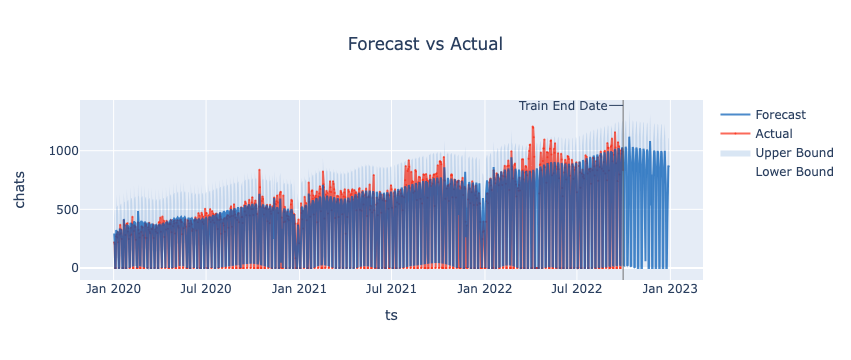

In [32]:
forecast = result.forecast
fig = forecast.plot()
plotly.io.show(fig)

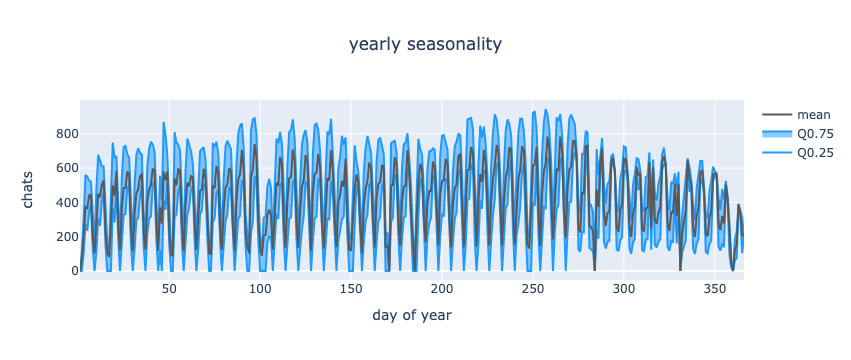

In [33]:
ts = result.timeseries  
fig = ts.plot_quantiles_and_overlays(
     groupby_time_feature="doy",
     show_mean=True,
     show_quantiles=[0.25, 0.75],  # specifies quantiles to include
     xlabel="day of year",
     ylabel=ts.original_value_col,
     title="yearly seasonality",
 )
plotly.io.show(fig)

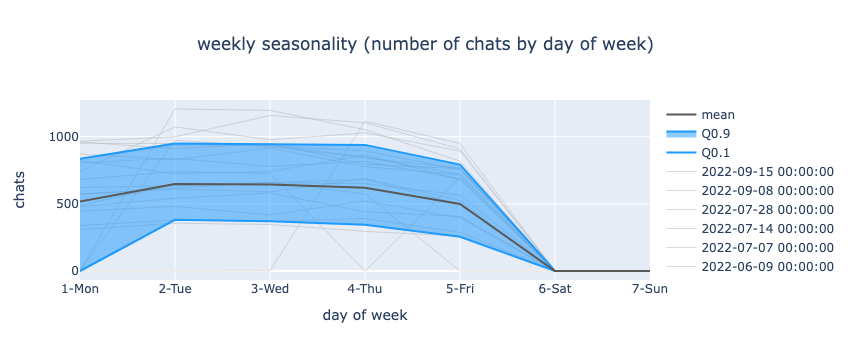

In [34]:
fig = ts.plot_quantiles_and_overlays(
    groupby_time_feature="str_dow",
    show_mean=True,
    show_quantiles=True,
    show_overlays=20,  # randomly selects up to 20 overlays
    overlay_label_sliding_window_size=7,  # each overlay is a single cycle (week)
    center_values=False,
    xlabel="day of week",
    ylabel=ts.original_value_col,
    title="weekly seasonality (number of chats by day of week)"
 )
plotly.io.show(fig)

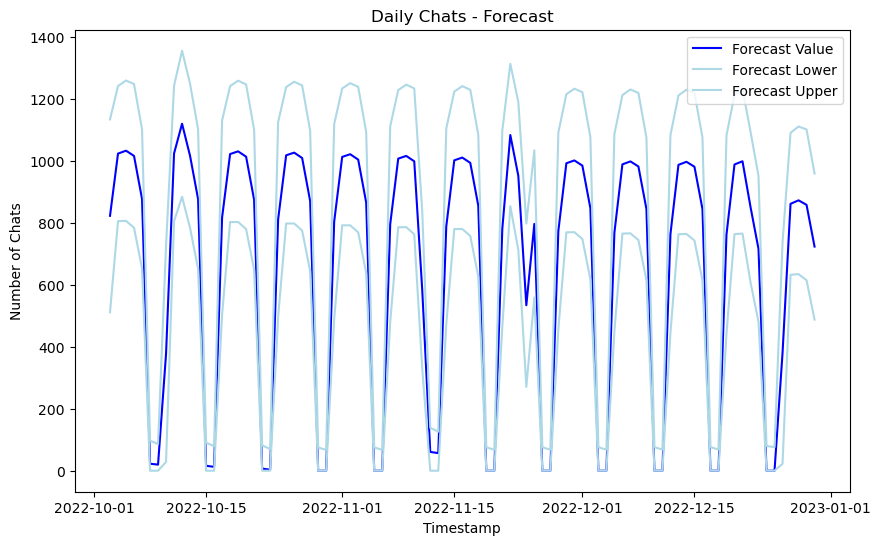

In [35]:
%matplotlib inline

plt.figure(figsize=(10, 6))
sns.lineplot(data=merged_df, x='ts', y='forecast', color='blue', label='Forecast Value')
sns.lineplot(data=merged_df, x='ts', y='forecast_lower', color='lightblue', label='Forecast Lower')
sns.lineplot(data=merged_df, x='ts', y='forecast_upper', color='lightblue', label='Forecast Upper')

plt.title('Daily Chats - Forecast')
plt.xlabel('Timestamp')
plt.ylabel('Number of Chats')
plt.legend()
plt.show()

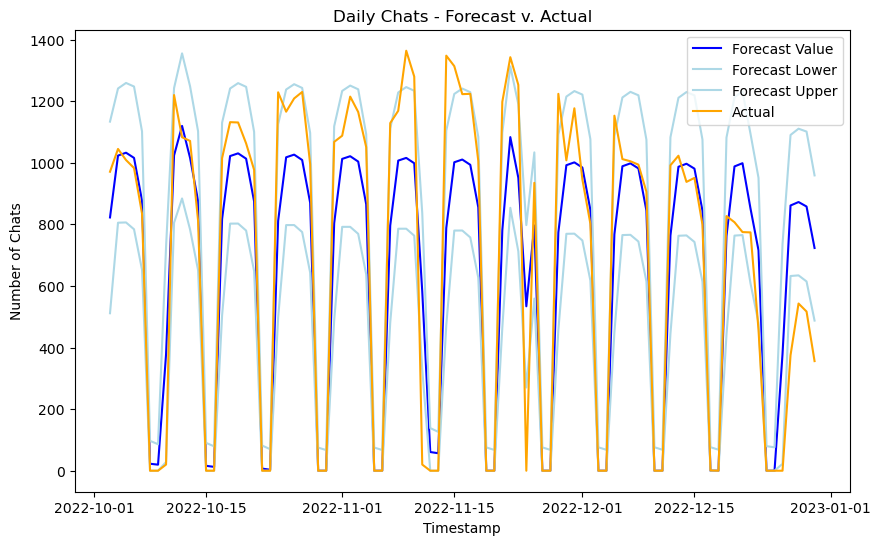

In [36]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=merged_df, x='ts', y='forecast', color='blue', label='Forecast Value')
sns.lineplot(data=merged_df, x='ts', y='forecast_lower', color='lightblue', label='Forecast Lower')
sns.lineplot(data=merged_df, x='ts', y='forecast_upper', color='lightblue', label='Forecast Upper')
sns.lineplot(data=merged_df, x='ts', y='chats', color='orange', label='Actual')

plt.title('Daily Chats - Forecast v. Actual')
plt.xlabel('Timestamp')
plt.ylabel('Number of Chats')
plt.legend()
plt.show()

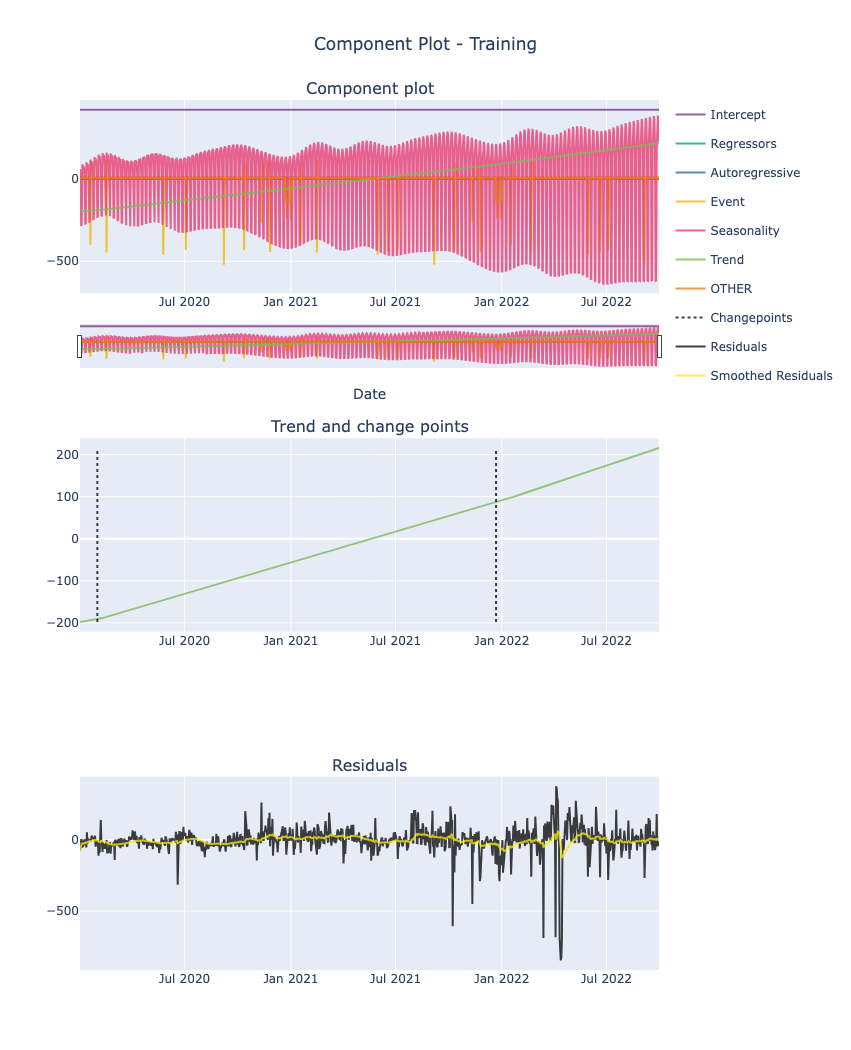

In [37]:
fig = forecast.plot_components()
plotly.io.show(fig) 